# STAT5243 Project 4: Causal Inference

**Group 2:**

    Wendy Doan
    Yibai Liu
    Yiwen Fang
    Shuqi Yu
    Zhihang Xia

***(To all) Things to do:***

    1) try other boosting methods (e.g. adaboost) for propensity score estimation
    2) time the models
    3) finish regression adjustment
    4) try reweighting & resampling

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


# Set a random seed for reproduction.
RANDOM_STATE = np.random.seed(2021)

# train-test split for propensity score
from sklearn.model_selection import train_test_split
# grid search
from sklearn.model_selection import GridSearchCV
# propensity score from tree models
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Stratification and Regression Adjustment
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression



In [2]:
# baseline propensity score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV


## Intro

## Exploring the data

In [3]:
highDim_dataset = pd.read_csv('../data/highDim_dataset.csv')
lowDim_dataset = pd.read_csv('../data/lowDim_dataset.csv')

In [99]:
high_true_ATE = -54.8558
low_true_ATE = 2.0901

In [4]:
highDim_dataset.shape

(2000, 187)

In [5]:
highDim_dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185
0,41.224513,0,0,1,4,18,17,-1,1,0.75,...,8,10,8,9,8,-1,-1,-1,-1,-1
1,40.513875,0,0,0,1,10,6,-1,10,0.35,...,6,5,6,8,5,-1,-1,-1,-1,-1
2,38.495476,0,0,0,16,8,4,4,4,0.40,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,33.001889,0,1,0,3,10,2,-1,5,0.41,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,37.043603,0,1,1,11,21,10,10,20,0.43,...,6,8,7,7,7,6,7,6,6,7


In [6]:
lowDim_dataset.shape

(500, 24)

In [7]:
lowDim_dataset.head()

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,30.486999,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,9.09,1.149622
1,18.208417,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,1.40,...,0.7,0.00,1.40,0.0,1.40,0.0,0.00,0.00,0.00,2.887702
2,13.485040,0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,3.57,0.0,0.00,0.0,0.00,0.00,0.00,0.000000
3,25.699678,1,2.38,0.00,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,2.38,0.0,2.38,0.0,0.00,0.00,0.00,0.405465
4,23.752968,0,0.15,0.15,0.05,0.1,0.0,0.42,0.1,0.95,...,0.0,0.36,3.16,0.0,1.58,0.0,0.52,0.31,0.00,1.574639


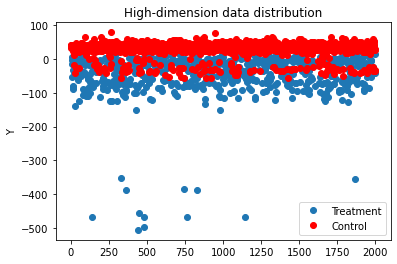

In [9]:
plt.plot(highDim_dataset[highDim_dataset.A == 1].Y, 'o', label="Treatment")
plt.plot(highDim_dataset[highDim_dataset.A == 0].Y, 'ro', label="Control")
plt.title("High-dimension data distribution")
plt.ylabel("Y")
plt.legend()
plt.show()

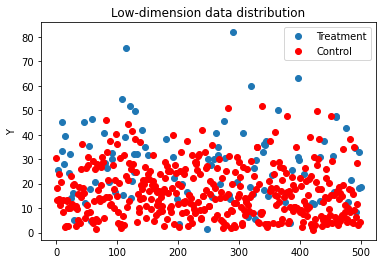

In [10]:
plt.plot(lowDim_dataset[lowDim_dataset.A == 1].Y, 'o', label='Treatment')
plt.plot(lowDim_dataset[lowDim_dataset.A == 0].Y, 'ro', label = 'Control')
plt.title("Low-dimension data distribution")
plt.ylabel("Y")
plt.legend()
plt.show()

#### Naive estimate of ATE

In [12]:
def naive_ATE(dataset):
    return np.average(dataset[dataset.A == 1].Y) - np.average(dataset[dataset.A == 0].Y)

In [13]:
# High-dimention
naive_ATE(highDim_dataset)

-75.17133436876799

In [14]:
# Low-dimention
naive_ATE(lowDim_dataset)

10.602068661915688

### Are the data sets balanced? 

In [ ]:
# For Chloe: go ahead if you want to resample/reweigh

In [17]:
print("High-dimention\nTreatment:", len(highDim_dataset[highDim_dataset.A == 1]), "\nControl:", len(highDim_dataset[highDim_dataset.A == 0]))

High-dimention
Treatment: 643 
Control: 1357


In [18]:
print("Low-dimention\nTreatment:", len(lowDim_dataset[lowDim_dataset.A == 1]), "\nControl:", len(lowDim_dataset[lowDim_dataset.A == 0]))

Low-dimention
Treatment: 106 
Control: 394


Slightly imbalanced, but acceptable.

### Split into train and test set 80:20

In [33]:
def split_train_test(dataset):
    X = np.array(dataset.iloc[:, 2:])
    y = np.array(dataset.Y)
    A = np.array(dataset.A)
    
    idx_train, idx_test, y_train, y_test = train_test_split(range(X.shape[0]), y, test_size=0.2, random_state=RANDOM_STATE)
    X_train = X[idx_train]
    X_test = X[idx_test]
    A_train = A[idx_train]
    A_test = A[idx_test]
    return X_train, X_test, y_train, y_test, A_train, A_test

# Split arrays into train and test set
X_high_train, X_high_test, y_high_train, y_high_test, A_high_train, A_high_test= split_train_test(highDim_dataset)
X_low_train, X_low_test, y_low_train, y_low_test, A_low_train, A_low_test= split_train_test(lowDim_dataset)

## Propensity Score - Logistic Regression (not needed?)

High dimensional data baseline

In [21]:
logisticRegr_high = LogisticRegression(max_iter=10000)

In [22]:
logisticRegr_high.fit(X_high_train, z_high_train)

LogisticRegression(max_iter=10000)

In [23]:
logisticRegr_high.score(X_high_train, z_high_train)

0.748125

In [24]:
logisticRegr_high.score(X_high_test, z_high_test)

0.71

Low dimensional data baseline

In [25]:
logisticRegr_low = LogisticRegression()

In [26]:
logisticRegr_low.fit(X_low_train, z_low_train)

LogisticRegression()

In [27]:
logisticRegr_low.score(X_low_train, z_low_train)

0.795

In [28]:
logisticRegr_low.score(X_low_test, z_low_test)

0.86

## Propensity Score - Boosted Stumps

#### Gradient Boosting

In [36]:
param_grid = {
              'learning_rate': [0.1,0.05,0.01],
              'max_depth': [2,3,5],
              'min_samples_split': [2, 4],
              'n_estimators': [100,150],
              'min_samples_leaf':[1,3,5]
              }

In [136]:
def grid_search(X:np.array, A:np.array, model, param_grid=param_grid, cv=10, print_step = True, sample_weight=None):
    """
    Takes a baseline model and does grid search among parameters in the param_grid with cross validation.
    Returns the model with best hyparameters after searching
    
    Inputs:
    -------
    X: np.array, feature set for fitting the model
    y: np.array, target for predictions
    model: an sklearn estimator object
    param_grid: dict, a dictionary that contains possible search values for parameters
    print_step: bool, whether to print detailed scores for each combination of parameters;
                set print_step=False to only report the best combination of parameters and the best scores
    sample_weight:np.array, instance weights, optional
    
    
    Output:
    -------
    The sklearn estimator object with hyperparameters set to be the best parameters from search 
    """
    if sample_weight is None:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A)
    else:
        clf = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1).fit(X, A, sample_weight = sample_weight)
    print("Best accuracy: %0.3f" % (clf.best_score_))
    print()
    print("Best parameters: %r" % clf.best_params_)
    print('-'*30)
    if print_step:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        		print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print('-'*30)

    return(model.set_params(**clf.best_params_))

In [38]:
gbm_high = grid_search(X_high_train, A_high_train, model=GradientBoostingClassifier(random_state=RANDOM_STATE))
gbm_low = grid_search(X_low_train, A_low_train, model=GradientBoostingClassifier(random_state=RANDOM_STATE))

Best accuracy: 0.728

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
------------------------------
0.721 (+/-0.076) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.712 (+/-0.060) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
0.721 (+/-0.077) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
0.713 (+/-0.067) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}
0.719 (+/-0.055) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.711 (+/-0.062) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150}
0.719 (+/-0.055) for {'learning_rate': 0.1, 'max_depth

Best accuracy: 0.810

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}
------------------------------
0.802 (+/-0.072) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.800 (+/-0.071) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
0.792 (+/-0.067) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
0.798 (+/-0.065) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150}
0.800 (+/-0.071) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
0.805 (+/-0.083) for {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150}
0.798 (+/-0.076) for {'learning_rate': 0.1, 'max_depth

In [ ]:
# A copy of best hyperparameters from grid search
# Can skip the last cell because grid search takes minutes
best_params_high = {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}
best_params_low = {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}

gbm_high = GradientBoostingClassifier(random_state=RANDOM_STATE).set_params(**best_params_high)
gbm_low = GradientBoostingClassifier(random_state=RANDOM_STATE).set_params(**best_params_low)

In [43]:
# Fit the models
gbm_high = gbm_high.fit(X_high_train, A_high_train)
gbm_low = gbm_low.fit(X_low_train, A_low_train)

# Predict the propensity scores
ps_high_train = gbm_high.predict_proba(X_high_train)[:, 1]
ps_low_train = gbm_low.predict_proba(X_low_train)[:, 1]

In [41]:
gbm_high.score(X_high_train, A_high_train)

0.78

In [42]:
gbm_low.score(X_low_train, A_low_train)

0.93

#### XG Boost (weighted)

In [152]:
param_grid_xgb = {
    'objective':['binary:logistic', 'reg:squarederror'],
    'n_estimators':[10,50,100],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1.0, 1.5],
    'subsample': [0.3, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'max_depth': [3, 4]#,
    #'scale_pos_weight':[1, 2, 4]
}

In [163]:
# Caution: This chunk is sloooooooooow, so maybe you wanna skip this cell and instead use the next 
# cell which gives the same results
xgb_high = grid_search(X_high_train, A_high_train, param_grid = param_grid_xgb, print_step=False, cv=5,
                       model=XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE))
xgb_low = grid_search(X_low_train, A_low_train, param_grid = param_grid_xgb, print_step=False,cv=5,
                      model=XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE))

Best accuracy: 0.733

Best parameters: {'colsample_bytree': 0.8, 'gamma': 1.0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.8}
------------------------------
[22:34:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best accuracy: 0.810

Best parameters: {'colsample_bytree': 0.6, 'gamma': 1.0, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'subsample': 0.8}
------------------------------


In [159]:
# A copy of best hyperparameters from grid search
# Can skip the last cell because grid search takes minutes
best_params_xgb_high = {'colsample_bytree': 0.8, 'gamma': 1.0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10, 
                        'objective': 'reg:squarederror', 'subsample': 0.8}
best_params_xgb_low = {'colsample_bytree': 0.6, 'gamma': 1.0, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50, 
                       'objective': 'binary:logistic', 'subsample': 0.8}

xgb_high = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb_high)
xgb_low = XGBClassifier(n_jobs=-1,random_state=RANDOM_STATE).set_params(**best_params_xgb_low)

In [160]:
# Fit the models
xgb_high = xgb_high.fit(X_high_train, A_high_train)
xgb_low = xgb_low.fit(X_low_train, A_low_train)

# Predict the propensity scores
ps_high_train_xgb = xgb_high.predict_proba(X_high_train)[:, 1]
ps_low_train_xgb = xgb_low.predict_proba(X_low_train)[:, 1]

[21:50:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [161]:
xgb_high.score(X_high_train, A_high_train)

0.76375

In [162]:
xgb_low.score(X_low_train, A_low_train)

0.8275

XGBoost with sample weights

In [145]:
#sample_weight_high = np.array([Counter(A_high_train)[0], Counter(A_high_train)[1]])
#print(sample_weight_high)

#sample_weight_low = np.array([Counter(A_low_train)[0], Counter(A_low_train)[1]])
#print(sample_weight_low)

[1090  510]
[317  83]


## Combine data

In [44]:
def combine_data(ps, A, y):
    """
    Combines propensity scores with A and y
    
    Returns a data frame with three columns
    """
    data = pd.DataFrame(
        np.array([ps, A, y]).T,
        columns=['e', 'A', 'Y']
    )
    return data

In [48]:
final_high_train = combine_data(ps_high_train, A_high_train, y_high_train)
final_low_train = combine_data(ps_low_train, A_low_train, y_low_train)


In [49]:
final_high_train

,e,A,Y
0,0.186506,0.0,29.464324
1,0.148604,0.0,35.066632
2,0.206732,1.0,1.905730
3,0.132638,0.0,64.143566
4,0.160921,0.0,33.243630
...,...,...,...
1595,0.099849,0.0,51.162041
1596,0.309059,0.0,39.025239
1597,0.335506,0.0,50.840262
1598,0.303552,0.0,29.919783


In [50]:
final_low_train

,e,A,Y
0,0.038699,0.0,11.548821
1,0.050136,0.0,50.806949
2,0.097208,0.0,35.171665
3,0.043380,0.0,13.485040
4,0.038215,0.0,1.685687
...,...,...,...
395,0.316687,1.0,16.075496
396,0.444751,1.0,28.155088
397,0.693904,1.0,30.458659
398,0.764128,1.0,35.063823


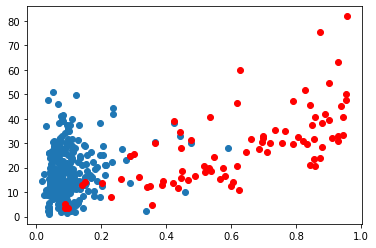

In [52]:
plt.plot(final_low_train[final_low_train.A==0].e, 
         final_low_train[final_low_train.A==0].Y, 'o')
plt.plot(final_low_train[final_low_train.A==1].e, 
         final_low_train[final_low_train.A==1].Y, 'ro')
plt.show()

## ATE Estimate - Stratification

In [53]:
def Stratify(data:pd.DataFrame, k:int):
    
    data_copy = data.copy()
    
    # rank to resolve duplicate edge cases
    data_copy['bin'] = pd.qcut(
        data_copy.e.rank(method='first'), k, labels=False
    )
    
    return data_copy

In [54]:
Stratify(final_high_train, 5).head()

,e,A,Y,bin
0,0.186506,0.0,29.464324,1
1,0.148604,0.0,35.066632,0
2,0.206732,1.0,1.905730,1
3,0.132638,0.0,64.143566,0
4,0.160921,0.0,33.243630,0


In [94]:
def Calculate_ATE_Strat(data:pd.DataFrame, k:int):
    
    N = data.shape[0]
    
    data_copy = Stratify(data, k)
    
    # calculate ATE score
    ATE = 0
    for j in range(k):
        
        # temporary data frame
        Qj = data_copy[data_copy.bin == j]
        Nj = Qj.shape[0]
        

        s0 = np.average((1- Qj[Qj.A==0].A) * Qj[Qj.A==0].Y)
        s1 = np.average(Qj[Qj.A==1].A* Qj[Qj.A==1].Y) if Qj[Qj.A==1].shape[0] != 0 else 0
        
        ATE += (Nj/N) * (s1 - s0)
    
    return ATE

In [95]:
Calculate_ATE_Strat(final_high_train, k=5)

-48.995228269475945

In [96]:
Calculate_ATE_Strat(final_low_train, k=5)

-7.982418219759196

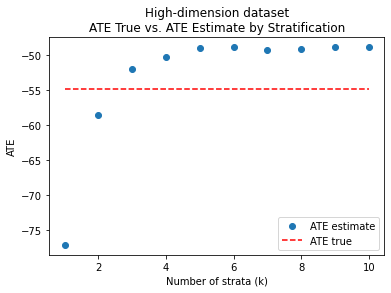

In [116]:
# Graph as functions of bins
plt.scatter(range(1,11), [Calculate_ATE_Strat(final_high_train, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(high_true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title("High-dimension dataset\nATE True vs. ATE Estimate by Stratification")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()

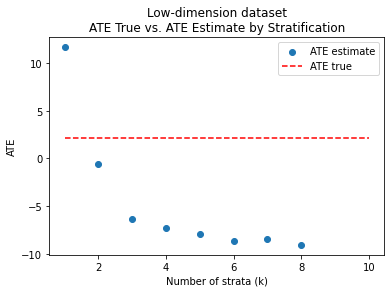

In [117]:
# Graph as functions of bins
plt.scatter(range(1,11), [Calculate_ATE_Strat(final_low_train, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(low_true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title("Low-dimension dataset\nATE True vs. ATE Estimate by Stratification")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()

## ATE Estimate - Regression Adjustment

In [164]:
def Calculate_ATE_RegrAdjusted(data:pd.DataFrame, X_data, k:int):
    #model here
    y = data.Y

## ATE Estimate - Regression Adjustment with Stratification

In [48]:
# Wendy to fill in

In [165]:
#Question from Chloe: Is this Regression with stratification instead of Regression adjustment with stratification?
def Calculate_ATE_StratRegrAdjusted(data:pd.DataFrame, X_data, k:int):
    
    N = data.shape[0]
    
    data_adjusted = pd.concat(
        [Stratify(data, k), X_data.reset_index(drop=True)], axis=1)
    
    # calculate ATE score
    ATE = 0
    for j in range(k):
        
        # temporary data frame
        Qj = data_adjusted[data_adjusted.bin == j]
        Nj = Qj.shape[0]
 
        # Regression Adjusted Linearly, then Delta_j = alpha^Z_j
        X = Qj.drop(['e', 'Y', 'bin'], axis=1)
        y = Qj.Y
        reg = LinearRegression().fit(X, y)
        
        ATE += reg.coef_[0]
    
    return ATE / k

In [168]:
Calculate_ATE_StratRegrAdjusted(final_high_train, pd.DataFrame(X_high_train), 1)

-59.82861751630885

In [138]:
Calculate_ATE_StratRegrAdjusted(final_low_train, pd.DataFrame(X_low_train), 1)

2.4902369721808086

In [117]:
Calculate_ATE_StratRegrAdjusted(final_high_train, pd.DataFrame(X_high_train), 5)

-54.51211689365348

In [118]:
Calculate_ATE_StratRegrAdjusted(final_low_train, pd.DataFrame(X_low_train), 5)

1.9847333675465868

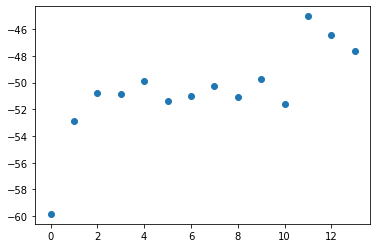

In [169]:
# Graph as functions of bins
plt.plot([Calculate_ATE_StratRegrAdjusted(final_high_train, pd.DataFrame(X_high_train), k) for k in range(1, 15)], 'o')
plt.show()

In [ ]:
# By Chloe

In [130]:
def Calculate_ATE_StratRegrAdjusted(data:pd.DataFrame, k:int):
    
    N = data.shape[0]
    
    data_copy = Stratify(data, k)
    
    # calculate ATE score
    ATE = 0
    for j in range(k):
        
        # stratum j
        Qj = data_copy[data_copy.bin == j]
        Nj = Qj.shape[0]
 
        X = Qj[['A','e']]
        y = Qj.Y
        reg = LinearRegression().fit(X, y)
        
        ATE += reg.coef_[0]
    
    return ATE / k

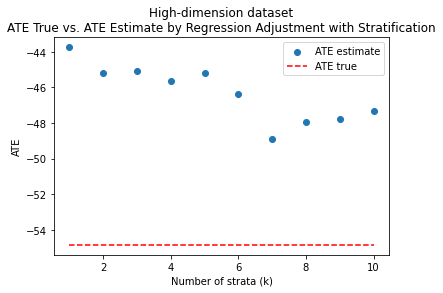

In [132]:
plt.scatter(range(1,11), [Calculate_ATE_StratRegrAdjusted(final_high_train, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(high_true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title("High-dimension dataset\nATE True vs. ATE Estimate by Regression Adjustment with Stratification")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()

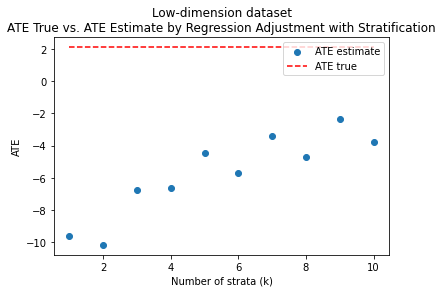

In [131]:
plt.scatter(range(1,11), [Calculate_ATE_StratRegrAdjusted(final_low_train, k) for k in range(1, 11)], label = 'ATE estimate')
plt.hlines(low_true_ATE, 1, 10, colors='red', linestyles='dashed', label='ATE true')
plt.title("Low-dimension dataset\nATE True vs. ATE Estimate by Regression Adjustment with Stratification")
plt.xlabel("Number of strata (k)")
plt.ylabel("ATE")
plt.legend()
plt.show()